<br/>

$$ \huge{\underline{\textbf{ Episodic Semi-Gradient Sarsa }}} $$

<br/>

<img src="assets/1001_Ep_Semi_Grad_Sarsa.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 10.1 </center>

<br/>

In [151]:
def ep_semi_grad_sarsa(env, ep, gamma, eps, Q_model, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        model      - function approximator, already initialised, with method:
                     train(state, target) -> None
    """
    def policy(st, Q_model, eps):
        if np.random.rand() > eps:
            q_vals = [Q_model.evaluate(st,a) for a in env.act_space]
            return argmax_rand(q_vals)
        else:
            return np.random.choice(env.act_space)
    
    for e_ in range(ep):
        S = env.reset()
        A = policy(S, Q_model, eps)
        
        for t_ in range(10**100):       
            S_, R, done = env.step(A)
            
            if done:
                Q_model.train(S, A, R)
                print('ep len', t_)
                break
                
            A_ = policy(S_, Q_model, eps)
            
            target = R + gamma * Q_model.evaluate(S_, A_)
            Q_model.train(S, A, target)
            
            S, A = S_, A_
                
            if callback is not None:
                callback(e_, t_, Q_model, trace)
                

Helper functions

In [102]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

In [80]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, nb_actions, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low      - state space low boundry in all dim, e.g. [-1.2, -0.07] for mountain car
            st_high     - state space high boundry in all dimensions
            nb_actions  - number of possible actions
            learn_rate  - step size, will be adjusted for nb_tilings automatically
            num_tilings - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val    - initial state-action values
        """
        assert len(st_low) == len(st_high)
#         def is_power_of_2(num):   
#             return num != 0 and ((num & (num - 1)) == 0)
#         if not is_power_of_2(num_tilings):    # required by tiling library
#             raise ValueError('num_tilings must be power of 2')
                
        
#         if self._num_tillings < 4 * num_dim:  # required by tiling library
#             raise ValueError('num_tilings must be >= four times state_space dimensions')
        
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        #
        #   Memory required to express whole state/action space
        #
        #   E.g.: 8 tilings, 2x state dimensions, 3x actions
        #   possible states:  (8+1)*(8+1)*(8) == 648
        #                     (dim_1_tiles+1, dim_2_tiles+1, nb_tiles)
        #   we need to add +1, becouse tiles go outside state space
        #   total possible states: possible states * nb_actions
        #                          648 * 3 = 1944
        #   note that actual memory requirement is slightly lower
        #   due to how tiles behave at the edges on n-dimensional qube
        #
        num_dim = len(st_low)
        nb_total_tiles = (num_tilings+1)**num_dim * num_tilings
        nb_total_tiles *= nb_actions
        
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def evaluate(self, state, action):
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(
            self._iht, self._num_tilings, scaled_state, [action])
        return np.sum(self._weights[active_tiles])       # pick correct weights and sum up

    def train(self, state, action, target):
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(
            self._iht, self._num_tilings, scaled_state, [action])
        value = np.sum(self._weights[active_tiles])
        delta = self._lr * (target - value)
        self._weights[active_tiles] += delta             # update active weights
        

Mountain Car

In [114]:
class MountainCarEnv:
    def __init__(self):
        self._pos = 0
        self._vel = 0
        self.state_low = np.array([-1.2, -0.07])
        self.state_high = np.array([0.5, 0.07])
        self.act_space = [0, 1, 2]
        self.nb_actions = 3
        self.reset()

    def reset(self):
        self._pos = np.random.uniform(-0.6, -0.4)
        self._vel = 0.0
        self._done = False
        return np.array([self._pos, self._vel], dtype=float)

    def step(self, action):
        assert self._done == False
        assert action in self.act_space

        self._vel = self._vel + 0.001*(action-1) - 0.0025*np.cos(3*self._pos)
        self._vel = min(max(self._vel, -0.07), 0.07)

        self._pos = self._pos + self._vel
        self._pos = min(max(self._pos, -1.2), 0.5)

        if self._pos == -1.2:
            self._vel = 0.0

        if self._pos == 0.5:
            obs = np.array([self._pos, self._vel], dtype=float)
            reward = -1
            self._done = True
            return obs, reward, self._done
        else:
            obs = np.array([self._pos, self._vel], dtype=float)
            reward = -1
            return obs, reward, self._done


In [148]:
env = MountainCarEnv()

In [155]:
model = TileCodingFuncApprox(env.state_low, env.state_high, env.nb_actions,
                             learn_rate=0.3, num_tilings=8, init_val=0)

In [158]:
ep_semi_grad_sarsa(env, ep=500, gamma=1.0, eps=0.1, Q_model=model)

ep len 118
ep len 158
ep len 185
ep len 156
ep len 145
ep len 152
ep len 150
ep len 150
ep len 151
ep len 143
ep len 196
ep len 111
ep len 190
ep len 196
ep len 157
ep len 116
ep len 177
ep len 152
ep len 120
ep len 178
ep len 173
ep len 151
ep len 151
ep len 140
ep len 238
ep len 160
ep len 164
ep len 116
ep len 152
ep len 157
ep len 147
ep len 124
ep len 119
ep len 144
ep len 190
ep len 152
ep len 156
ep len 152
ep len 146
ep len 119
ep len 143
ep len 144
ep len 143
ep len 177
ep len 166
ep len 201
ep len 156
ep len 131
ep len 125
ep len 115
ep len 110
ep len 166
ep len 119
ep len 147
ep len 163
ep len 166
ep len 111
ep len 161
ep len 155
ep len 154
ep len 143
ep len 207
ep len 195
ep len 155
ep len 152
ep len 148
ep len 146
ep len 147
ep len 149
ep len 118
ep len 153
ep len 153
ep len 185
ep len 152
ep len 147
ep len 150
ep len 153
ep len 154
ep len 152
ep len 149
ep len 153
ep len 146
ep len 154
ep len 160
ep len 161
ep len 156
ep len 111
ep len 116
ep len 112
ep len 153
ep len 115

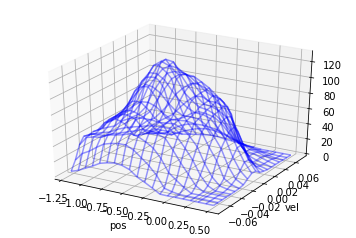

In [163]:
plot_Q_model(model)

In [160]:
pos_min, pos_max = env.state_low[0], env.state_high[0]
vel_min, vel_max = env.state_low[1], env.state_high[1]

q_arr = np.zeros([20, 20, 3])

for pi, pos in enumerate(np.linspace(pos_min, pos_max, 20)):
    for vi, vel in enumerate(np.linspace(vel_min, vel_max, 20)):
        for act in range(env.nb_actions):
            val = model.evaluate(state=[pos, vel], action=act)
            # print(pos, vel, act, ' -> ', val)
            q_arr[pi, vi, act] = model.evaluate(state=[pos, vel], action=act)

In [120]:
q_arr

array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 

In [161]:
def plot_Q_model(model):
    pos_min, pos_max = env.state_low[0], env.state_high[0]
    vel_min, vel_max = env.state_low[1], env.state_high[1]

    q_arr = np.zeros([20, 20, 3])

    for pi, pos in enumerate(np.linspace(pos_min, pos_max, 20)):
        for vi, vel in enumerate(np.linspace(vel_min, vel_max, 20)):
            for act in range(env.nb_actions):
                val = model.evaluate(state=[pos, vel], action=act)
                # print(pos, vel, act, ' -> ', val)
                q_arr[pi, vi, act] = model.evaluate(state=[pos, vel], action=act)
                
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    q_val = q_arr[:,:,0]

    plot_q_val_wireframe(ax, -q_val, extent=[-1.2, 0.5, -0.07, 0.07],
                         labels=['pos', 'vel', ''], color='blue', alpha=0.4)

In [95]:
def plot_q_val_wireframe(ax, q_val, extent, labels, color, alpha):
    """Plot 2d q_val array on 3d wireframe plot.
    
    Params:
        ax: axis to plot on
        q_val: 2d numpy array as follows:
               1-st dim is X, increasing as indices grow
               2-nd dim is Y, increasing as indices grow
        extent: [x_min, x_max, y_min, y_max]
        labels: [x_label, y_label, z_label]
    """

    assert len(extent) == 4
    assert len(labels) == 3

    x_min, x_max, y_min, y_max = extent
    x_label, y_label, z_label = labels

    x_size = q_val.shape[0]
    y_size = q_val.shape[1]
    x_space = np.linspace(x_min, x_max, x_size)
    y_space = np.linspace(y_min, y_max, y_size)

    Y, X = np.meshgrid(y_space, x_space)
    
    ax.plot_wireframe(X, Y, q_val, color=color, alpha=alpha)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)